# Fitting Data with a Line

Many of you have probably used Excel to fit data with a line.

![excel_linear_regression](img/excel_linear_regression.jpg)

We're going to review the math involved in this process to help understand how training an AI works.

First we will load some tools that others wrote and we can use to help us work.
* [Pandas](https://pandas.pydata.org/docs/): a toolkit for working with row vs. column data, like excel sheets, and CSV (Comma Seperated Values) files.
* [Numpy](https://numpy.org/doc/): a toolkit for managing arrays, vectors, matrices, etc, doing math with them, slicing them up, and many other handy things.
* [Matplotlib](https://matplotlib.org/stable/index.html): a toolkit for plotting data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

# Dataset
In the [previous notebook](00_make_slimmed_dataset.ipynb) we used a realestate dataset from Kaggle to produce this reduced dataset. This dataset contains the _sale price_ and _above ground square feet_ of many houses. We can use this data for our linear regression.

We use Pandas to read the data file which is stored as Comma Separated Values (CSV). and print the column labels. CSV files are similar to excel sheets.

In [8]:
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)

Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')


Now pandas provides some helpful tools for us to inspect our data. It provides a `plot()` function that, behind the scenes, is calling into the _Matplotlib_ library and calling the function [matplotlib.pyplot.plot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). In this case, we simply tell it the names of the columns we want as our _x_ and _y_ values and the `style` (`'.'` tells `matplotlib` to use a small dot to represent each data point).

<AxesSubplot:xlabel='GrLivArea'>

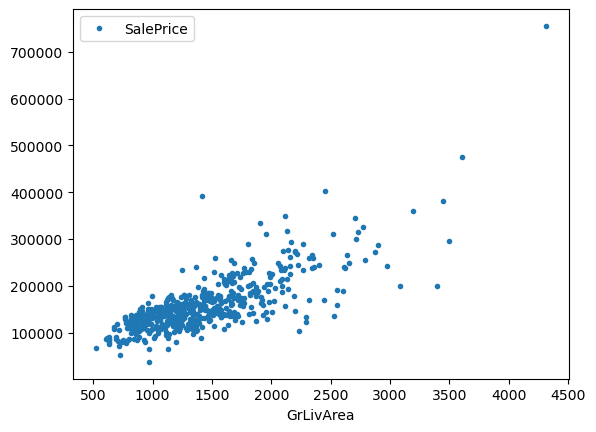

In [9]:
data.plot(x='GrLivArea',y='SalePrice',style='.')

# Linear Regression

If you have data, $(x,y)$, that you think can be fit by a line, $y = m x + b$, then there are [simple equations](https://en.wikipedia.org/wiki/Simple_linear_regression) one can use to calculate the slope ($m$) and intercept ($b$).

They are:

$$m = { n (\Sigma xy) - (\Sigma x) (\Sigma y) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

$$b = { (\Sigma y) (\Sigma x^2) - (\Sigma x) (\Sigma xy) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

We'll break this calculation into a few steps to help make it easier.

First lets define $x$ and $y$. $x$ will be our _above ground square footage_ and $y$ will be _sale price_. In our equations we have a few different values we need, such as $n$ which is just the number of points we have:

In [10]:
n = len(data)

Then we need our $x$ and $y$ by selecting only the column we care about for each one. Note about data formats: `data` is a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) object which has rows and columns; `data['GrLivArea']` is a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object which only has rows; then we also convert from _Pandas_ data formats (in this case a _Series_) to _Numpy_ data formats using the `to_numpy()` function which is part of the Pandas _Series_ object. 

In [11]:
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()

Now we will calculate $\Sigma xy$, $\Sigma x$, $\Sigma y$, and $\Sigma x^2$:

In [12]:
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)

The denominator in the equation for $m$ and $b$ are the same so we can calculate that once:

In [13]:
denominator = n * sum_x2 - sum_x * sum_x

Then we can calculate our fit values:

In [14]:
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b

y = 87.688145 * x + 34754.077892


Now we can plot the fit results with our data to see how we did. 

First we define a plotting function because we're going to do this often and we want to reuse our code:

In [18]:
def plot_data(x,y,m,b):
   # plot our data points with 'bo' = blue circles
   plt.plot(x,y,'bo')
   # create the line based on our linear fit
   # first we need to make x points
   # the 'arange' function generates points between two limits (min,max)
   linear_x = np.arange(x.min(),x.max())
   # now we use our fit parameters to calculate the y points based on our x points
   linear_y = linear_x * m + b
   # plot the linear points using 'r-' = red line
   plt.plot(linear_x,linear_y,'r-')

Now can use this function to plot our results:

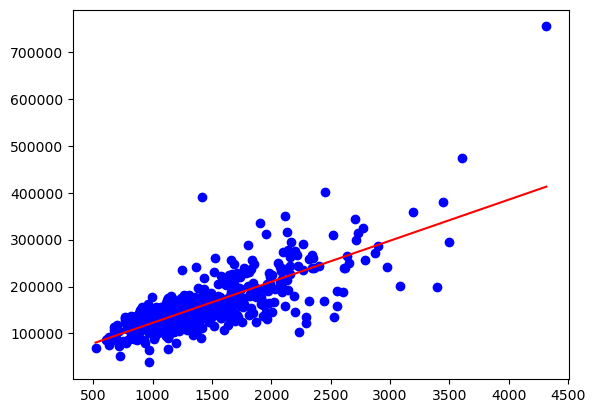

In [17]:
plot_data(x,y,m,b)

# Stochastic Gradient Descent

SGD is a common method in AI for training deep neural networks on large datasets. It is an iterative method for optimizing a loss function that we get to define. We will use this simple linear regression to demonstrate how it works.

# The model

In AI, neural networks are often referred to as a _model_ because, once fully trained, they should model (AKA predict) the behavior of our system. In our example, the system is how house prices vary based on house size. We know our system is roughly driven by a linear function:

$$ \hat{y_i}(x_i) = m * x_i + b $$

We just need to figure out $m$ and $b$. Let's create a function that calculates our model given $x$, $m$, and $b$.


In [19]:
def model(x,m,b):
   return m * x + b


# The Loss Function

A _loss function_, or _objective function_, is something we define and is based on what we want to achieve. In the method of SGD, it is our goal to minimize (or make close to zero) the values calculated from the _loss function_. In our example, we ideally want the prediction of our _model_ to be equal to the actual data, though we will settle for "as close as possible".

So our _loss function_ looks like this:

$$ L(y_i,\hat{y_i}) = (y_i - \hat{y_i}(x_i))^2 $$

where $y_i$ is our $i^{th}$ entry in the `data['SalePrice']` vector and $\hat{y_i}$ is the prediction based on evaluting $m * x_i + b$.

Here we crate a function that calculates this for us.

In [20]:
def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

# Minimizing the Loss Function

We want to use the loss function in order to guide how to update $m$ and $b$ to better model our system. In calculus we learn to minimize a function with respect to a variable you calculate the _partial derivative_ with respect to the variable you want to vary.

$$ { \partial L \over \partial m } = 0 $$

$$ { \partial L \over \partial m } = -2 x_i (y_i - \hat{y_i}(x_i)) $$
$$ { \partial L \over \partial b } = -2 (y_i - \hat{y_i}(x_i)) $$

We can use this to calculate an adjustment to $m$ and $b$ that will reduce the loss function, effectively improving our fitting parameters. This is done using this equation:

$$ m' = m - \eta { \partial L \over \partial m }$$
$$ b' = b - \eta { \partial L \over \partial b }$$

Here our original $m$ and $b$ are adjusted by the partial derivative multiplied by some small factor, $\eta$, called the _learning rate_. This learning rate is very important in our process and must be tuned for every problem.

In [40]:
def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.sum(dL_dm,axis=0) / np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.sum(dL_db,axis=0) / np.mean(dL_db)
   return b - learning_rate * dL_db

# Putting it together

We can now randomly select our initial slope and intercept:

In [34]:
m = 5.
b = 1000.
print('y_i = %.2f * x + %.2f' % (m,b))

y_i = 5.00 * x + 1000.00


Then we can calculate our Loss function:

In [35]:
l = loss(x,y,m,b)
print('first 10 loss values: ',l[:10])

first 10 loss values:  [3.92317249e+10 1.30965136e+10 2.29128769e+10 6.08534892e+10
 1.89076250e+10 8.86610560e+09 1.08128802e+10 1.49279524e+10
 2.90344560e+10 2.63023524e+10]


y_i = 75764538009161857343932541190655535108564388599508899013619166767876604135700282481318774693393530691357559972905744960382898731139028727849819208285982120163932190746950189973504.00 * x + -23108644718695316667597346051168318356122621616326323482865607625461880007675614229701854413678271329615124523162984129837874266945055083591109998697556379128688235277346562556420947968.00     previously calculated: y_i = 87.69 * x + 34754.08


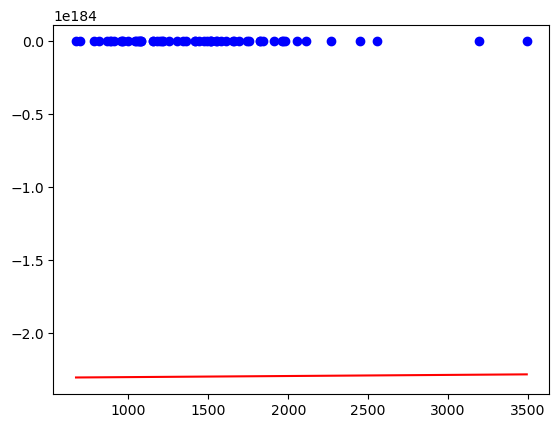

In [38]:
learning_rate = 1e-9
m = updated_m(x,y,m,b,learning_rate)
b = updated_b(x,y,m,b,learning_rate)
print('y_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f' % (m,b,m_calc,b_calc))
plot_data(x,y,m,b)

y_i = 3.20 * x + 998.20     previously calculated: y_i = 87.69 * x + 34754.08


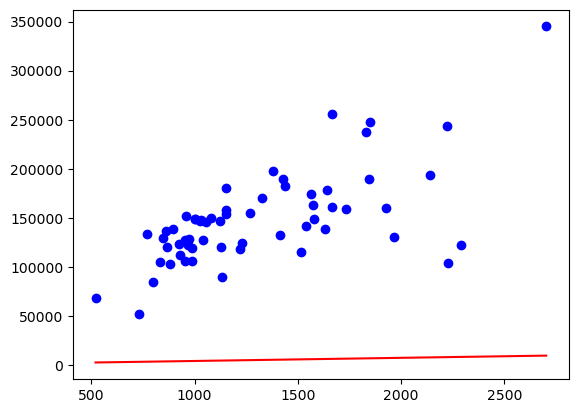

In [48]:
m = 5.
b = 1000.
batch_size = 60
learning_rate = 1e-9
for i in range(100):
   data_batch = data.sample(batch_size)
   x = data_batch['GrLivArea'].to_numpy()
   y = data_batch['SalePrice'].to_numpy()

   m = updated_m(x,y,m,b,learning_rate)
   b = updated_b(x,y,m,b,1e6*learning_rate)
   print('y_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f' % (m,b,m_calc,b_calc))
   plt.close('all')
   plot_data(x,y,m,b)
   plt.show()
   time.sleep(0.5)
   plt.close('all')
   ipydis.clear_output(wait=True)
